In [118]:
import sys
import os
import warnings
from pathlib import Path
sys.path.append(os.getenv("SPIKECOUNTER_PATH"))

from spikecounter.analysis import traces, images
import spikecounter.analysis.stats as sstats
from spikecounter.ui import visualize
from spikecounter import utils

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from skimage import filters, exposure
import os
import scipy.io as scio
import colorcet as cc
import skimage.io as skio
from sklearn import decomposition
from sklearn.utils.extmath import randomized_svd

biopubs_style = Path(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
plt.style.use(
    biopubs_style
)
warnings.filterwarnings("once")

In [6]:
rootdir = Path(os.getenv("DATA_ROOTDIR"), "20230329_agarose_encased_noABTX")
data_dir = os.path.join(rootdir, "corrected")
output_data_dir = Path(os.getenv("OUTPUT_DATADIR"), "Figure1/20230315_noABTX_widefield")
os.makedirs(output_data_dir, exist_ok=True)

Staging:

* E1 - 19 ss at 6AM
* E2 - 18 ss at 6AM
* E3 - 19 ss at 6AM

In [7]:
fs=10.2
start_hpf = 19
expt_info = pd.read_csv(rootdir/"analysis/experiment_data.csv").sort_values("start_time").reset_index()
start_times = [datetime.strptime(t,"%H:%M:%S") for t in list(expt_info["start_time"])]
offsets = [s - start_times[0] for s in start_times]
offsets = [o.seconds for o in offsets]
expt_info["offset"] = offsets
expt_info["hpf"] = start_hpf + expt_info["offset"]/3600

In [8]:
file_name = "084701_no_ABTX_t50_p1_z1"
file_path = Path(data_dir, file_name + ".tif")
img = skio.imread(file_path)

In [45]:
embryo_mask = skio.imread(rootdir/"analysis/manual_whole_embryo_masks.tif")
heart_masks = skio.imread(rootdir/"analysis/corrected/ROIs.tif")

In [67]:
embryo_mask_index = np.unique(embryo_mask[heart_masks==4])[0]
rd, gc = images.extract_region_data(img-img.mean(axis=0), embryo_mask, embryo_mask_index)

In [70]:
rd_mask, gc_mask = images.extract_region_data(heart_masks[None,...], embryo_mask, embryo_mask_index)

In [123]:
cropped_heart_mask = images.extract_cropped_region_image(rd_mask, gc_mask).astype(bool)

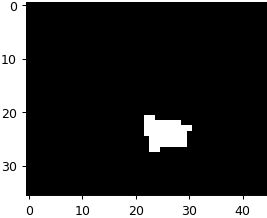

In [79]:
plt.imshow(cropped_heart_mask, cmap="gray")

In [119]:
nonheart_mean_trace = rd[:,np.squeeze(~rd_mask.astype(bool))].mean(axis=1)
regressed_video = images.extract_cropped_region_image(sstats.multi_regress(rd, nonheart_mean_trace), gc)


In [126]:
skio.imsave(output_data_dir/"regressed_video.tif", exposure.rescale_intensity(regressed_video, out_range=np.uint16))

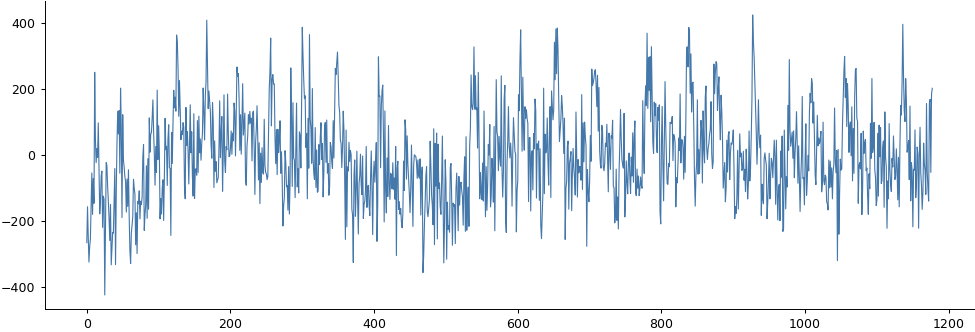

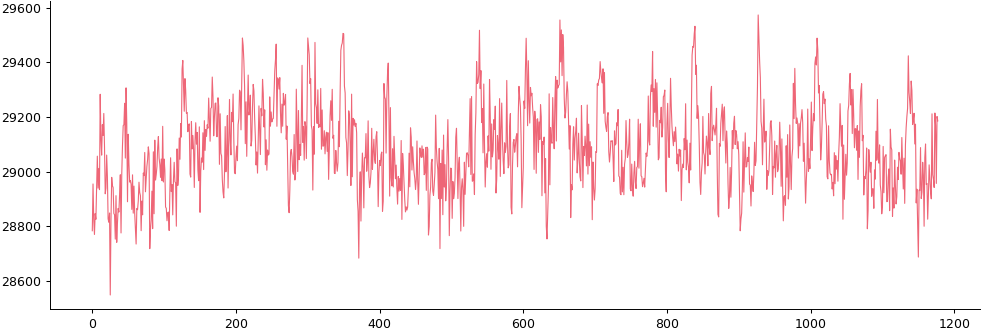

In [128]:
fig1, ax1 = plt.subplots(1,1, figsize=(12,4))
ax1.plot(images.extract_mask_trace(regressed_video, cropped_heart_mask))
fig1, ax2 = plt.subplots(figsize=(12,4))

ax2.plot(images.extract_mask_trace(img, heart_masks == 4), color="C1")

In [114]:
nonheart_mean_trace.shape

(1178, 1049)

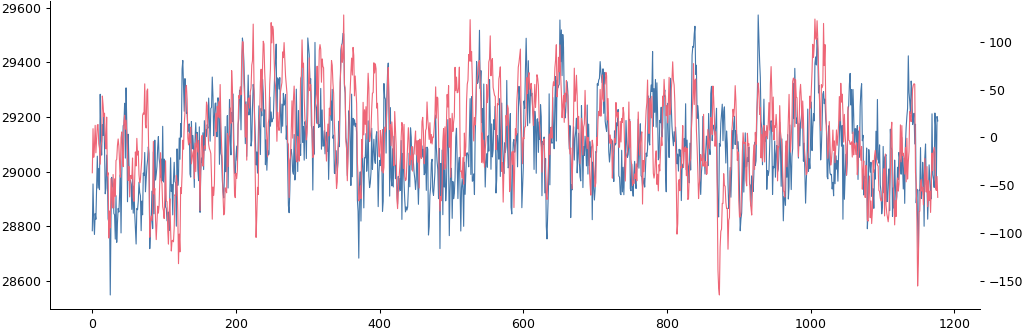

In [73]:
fig1, ax1 = plt.subplots(figsize=(12,4))
embryo_mean_trace = np.mean(rd, axis=1)
ax1.plot(images.extract_mask_trace(img, heart_masks == 4))
ax2 = ax1.twinx()
ax2.plot(embryo_mean_trace, color="C1")

In [82]:
mdl = decomposition.PCA(n_components=10)
mdl.fit(rd.T)

PCA(n_components=10)

In [83]:
mdl.components_[0].shape

(1178,)

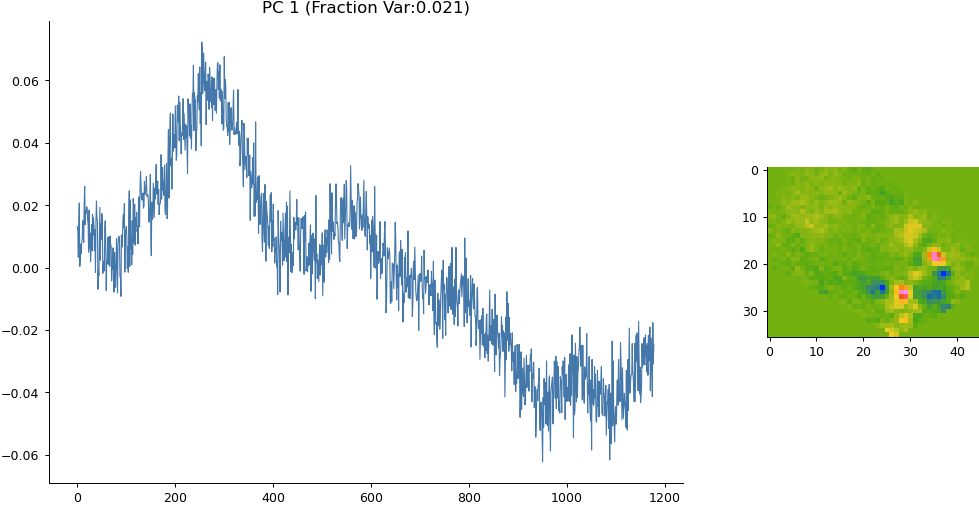

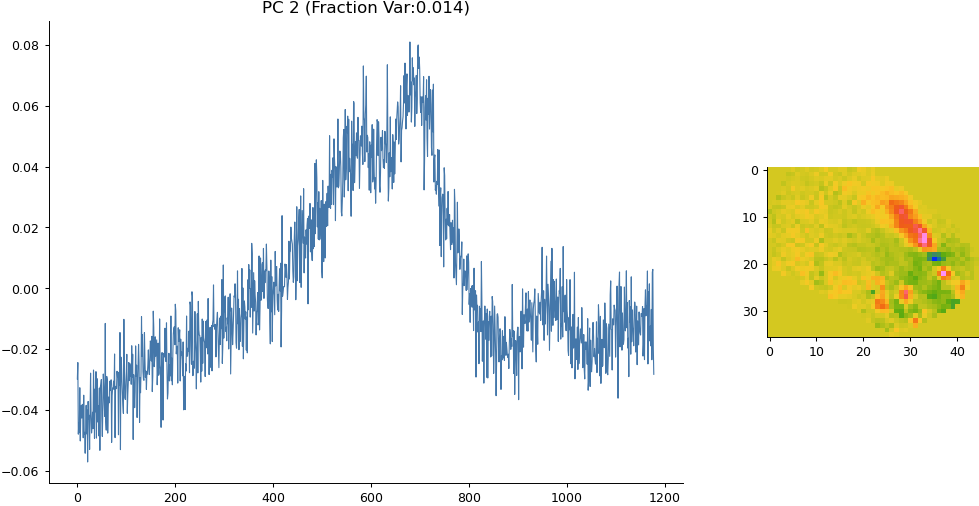

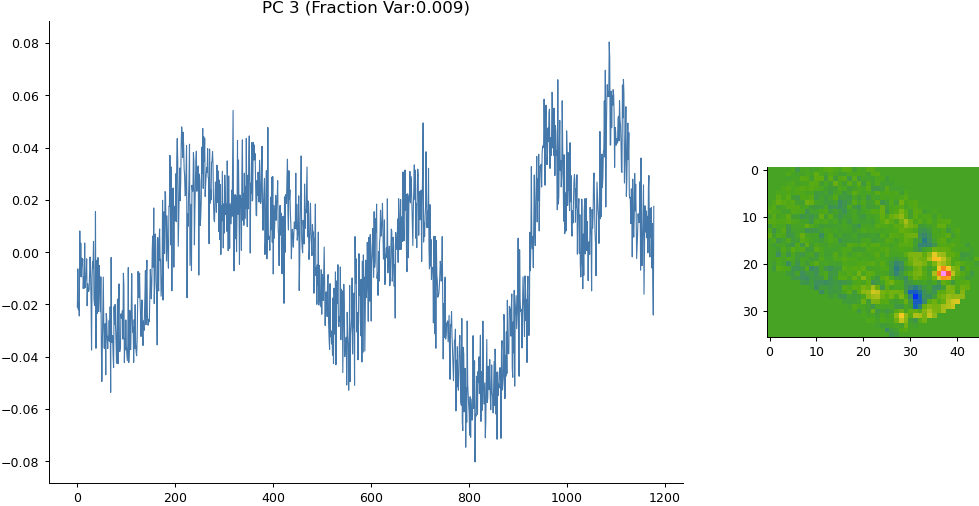

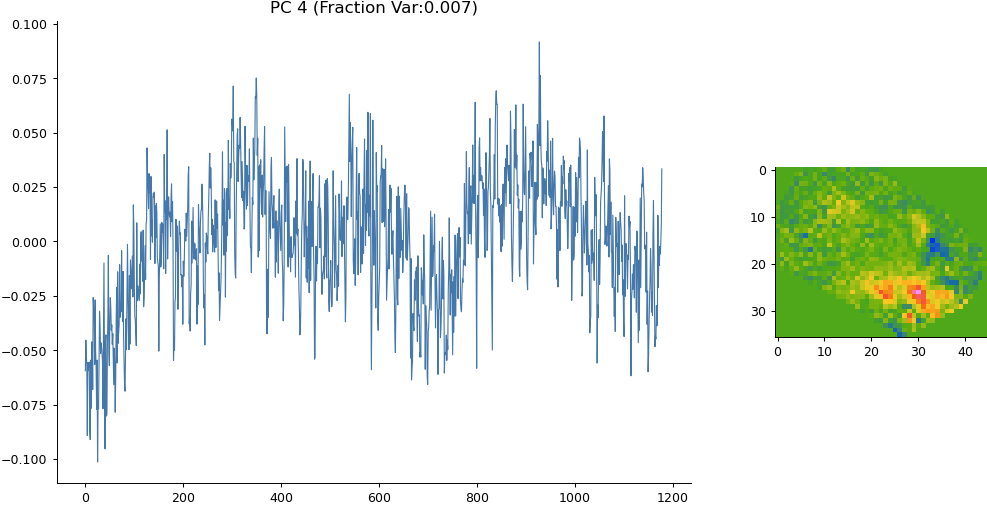

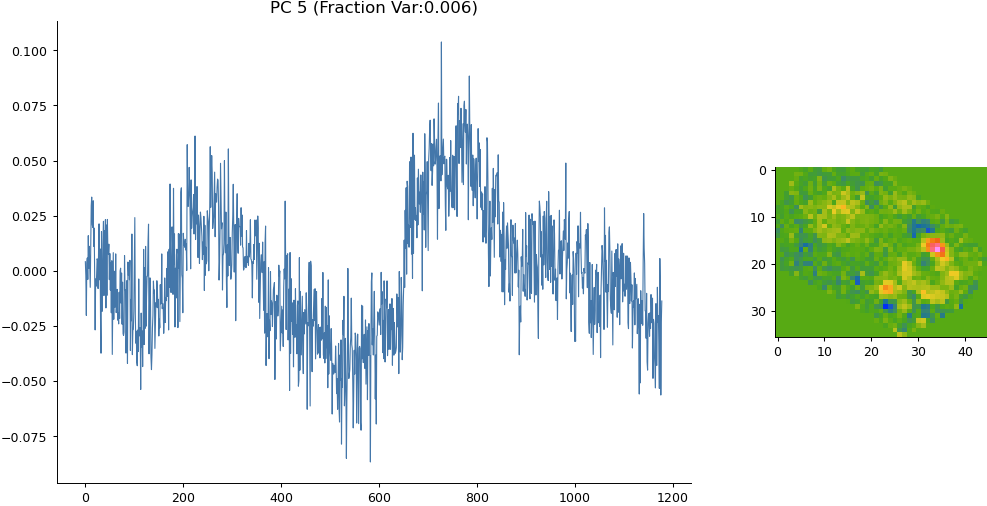

In [84]:
visualize.plot_pca_data(mdl, rd.T, gc, mode="spatial")

In [87]:
u, s, v = randomized_svd(rd.T, n_components=10)

In [102]:
comp_vid = images.extract_cropped_region_image(np.outer(u[:,3], v[3,:]).T, gc)

In [105]:
comp_vid.dtype

dtype('float64')

In [107]:
skio.imsave(output_data_dir/"pca_component_3.tif", exposure.rescale_intensity(comp_vid, out_range="uint16"))